In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder

In [3]:
df = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [4]:
df.columns

Index(['Year_Factor', 'State_Factor', 'building_class', 'facility_type',
       'floor_area', 'year_built', 'energy_star_rating', 'ELEVATION',
       'january_min_temp', 'january_avg_temp', 'january_max_temp',
       'february_min_temp', 'february_avg_temp', 'february_max_temp',
       'march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
       'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp',
       'may_max_temp', 'june_min_temp', 'june_avg_temp', 'june_max_temp',
       'july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
       'august_avg_temp', 'august_max_temp', 'september_min_temp',
       'september_avg_temp', 'september_max_temp', 'october_min_temp',
       'october_avg_temp', 'october_max_temp', 'november_min_temp',
       'november_avg_temp', 'november_max_temp', 'december_min_temp',
       'december_avg_temp', 'december_max_temp', 'cooling_degree_days',
       'heating_degree_days', 'precipitation_inches', 'snowfall_inc

## Data cleaning

In [5]:
# clean up data type
categorical_cols = [
    c
    for c in df.columns
    if (1 < df[c].nunique()) & (df[c].dtype != np.number) & (df[c].dtype != int)
]
categorical_cols
for col in categorical_cols:
    df[col] = df[col].astype("category")
categorical_cols

/var/folders/jw/71kz1mm55lj8zynw1gmlz4_m0000gn/T/ipykernel_4049/1431433008.py:5: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (1 < df[c].nunique()) & (df[c].dtype != np.number) & (df[c].dtype != int)


['State_Factor', 'building_class', 'facility_type']

### Missing data

In [6]:
# Check for missing data
cols_with_missing = [col for col in df.columns if df[col].isnull().any()]
miss_count = df.isna().sum()
miss_count.div(len(df))[cols_with_missing]

year_built                   0.024249
energy_star_rating           0.352561
direction_max_wind_speed     0.542287
direction_peak_wind_speed    0.551909
max_wind_speed               0.542287
days_with_fog                0.604512
dtype: float64

In [7]:
# Dropping variables with > 40% missing
col = ['direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
df.drop(col, axis=1, inplace=True)
test_data.drop(col, axis=1, inplace=True)

In [8]:
# fill year_built
# for 6 rows with year_built = 0, fill with the mean of the facility_type, which is 1963 for Lodging_Hotel
df[df['year_built'] == 0]
df['year_built'] = df['year_built'].apply(lambda x: 1963 if x==0 else x)

# for other 1800 rows, fill with the mean year_built of that state
year_built_dict = df.groupby('State_Factor')['year_built'].agg({'mean'}).to_dict()['mean']

for i in df['State_Factor'].unique():
    v = year_built_dict[i]
    index = df[df['State_Factor'] == i].index
    df.loc[index,'year_built'] = df.loc[index,'year_built'].apply(lambda x: v if np.isnan(x) else x) 

for i in test_data['State_Factor'].unique():
    v = year_built_dict[i]
    index = test_data[test_data['State_Factor'] == i].index
    test_data.loc[index,'year_built'] = test_data.loc[index,'year_built'].apply(lambda x: v if np.isnan(x) else x) 

In [9]:
def facility_type(x):
    if x.find('Warehouse') >= 0:
        type = 'Warehouse'
    elif x.find('Data') >= 0:
        type = 'Data'
    elif x.find('ducation') >= 0:
        type = 'Education'
    elif x.find('Commercial') >= 0:
        type = 'Commercial'
    elif x.find('Residential') >= 0:
        type = 'Residential'
    elif x.find('Industrial') >= 0:
        type = 'Industrial'
    elif x.find('ealth') >= 0:
        type = 'Health'  
    elif x.find('Retail') >= 0:
        type = 'Retail'
    elif x.find('Retail') >= 0:
        type = 'Retail'
    elif x.find('Office') >= 0:
        type = 'Office'
    elif x.find('Lodging') >= 0:
        type = 'Lodging'
    elif x.find('arket') >= 0:
        type = 'Market'
    elif x.find('Public') >= 0:
        type = 'Public'
    elif x.find('ervice')>= 0:
        type = 'Service'
    elif x.find('Food')>= 0:
        type = 'Service'      
    elif x.find('Religious') >= 0:
        type = 'Religious'        
    elif x.find('Parking') >= 0:
        type = 'Parking'          
    elif x.find('uilding') >= 0:
        type = 'Building'      
    elif x.find('ultifamily') >= 0:
        type = 'Multifamily'   
    elif x.find('Laboratory') >= 0:
        type = 'Laboratory'           
    elif x.find('Nursing_Home') >= 0:
        type = 'Nursing_Home'         
    else:
        type = 'Other'
    return type
df['facility_type_s'] = df['facility_type'].apply(facility_type)
test_data['facility_type_s'] = test_data['facility_type'].apply(facility_type)

#col = ['facility_type']
#df.drop(col, axis=1, inplace=True)
#test_data.drop(col, axis=1, inplace=True)

In [10]:
# see how much na values in each facility_type_s
df[df["energy_star_rating"].isna()].groupby('facility_type_s')['id'].count()

facility_type_s
Building          469
Commercial       2282
Data               18
Education        1956
Health            191
Industrial        341
Laboratory        105
Lodging           289
Market             43
Multifamily     16411
Nursing_Home       77
Office           1393
Parking           242
Public            953
Religious          76
Residential         1
Retail            559
Service           319
Warehouse         984
Name: id, dtype: int64

In [11]:
# fill energy_star_rating
energy_dict = df.groupby("facility_type_s")["energy_star_rating"].mean().to_frame().to_dict()['energy_star_rating']
#energystar_by_facility = df.groupby("facility_type_s")["energy_star_rating"].mean().to_frame().reset_index()
#energy_dict={}
#for i in range(len(energystar_by_facility)):
#    energy_dict[energystar_by_facility.iloc[i][0]] = round(energystar_by_facility.iloc[i][1], 2)
    
facility_type = ['Market', 'Warehouse', 'Retail', 'Education', 'Office', 'Data',
       'Commercial', 'Industrial', 'Laboratory', 'Public', 'Lodging',
       'Health', 'Religious', 'Parking', 'Service', 'Nursing_Home',
       'Building', 'Multifamily', 'Residential']

for i in facility_type:
    v = energy_dict[i]
    index = df[df['facility_type_s'] == i].index
    df.loc[index,'energy_star_rating'] = df.loc[index,'energy_star_rating'].apply(lambda x: v if np.isnan(x) else x)
    
for i in facility_type:
    v = energy_dict[i]
    index = test_data[test_data['facility_type_s'] == i].index
    test_data.loc[index,'energy_star_rating'] = test_data.loc[index,'energy_star_rating'].apply(lambda x: v if np.isnan(x) else x)    

### Concat columns

In [12]:
# caculate the percentage of cooling days and heating days
df['days'] = df['cooling_degree_days'] + df['heating_degree_days']
df['cooling_degree_days_pct'] = df['cooling_degree_days']/df['days']
df['heating_degree_days_pct'] = df['heating_degree_days']/df['days']

test_data['days'] = test_data['cooling_degree_days'] + test_data['heating_degree_days']
test_data['cooling_degree_days_pct'] = test_data['cooling_degree_days']/test_data['days']
test_data['heating_degree_days_pct'] = test_data['heating_degree_days']/test_data['days']

col = ['cooling_degree_days', 'heating_degree_days','days']
df.drop(col, axis=1, inplace=True)
test_data.drop(col, axis=1, inplace=True)

In [13]:
# concat days below and days above certain degrees
df['days_below_F'] = df['days_below_30F']+df['days_below_20F']+df['days_below_10F']+df['days_below_0F']
df['days_above_F'] = df['days_above_80F']+df['days_above_90F']+df['days_above_100F']+df['days_above_110F']

test_data['days_below_F'] = test_data['days_below_30F']+test_data['days_below_20F']+test_data['days_below_10F']+test_data['days_below_0F']
test_data['days_above_F'] = test_data['days_above_80F']+test_data['days_above_90F']+test_data['days_above_100F']+test_data['days_above_110F']

col = ['days_below_30F','days_below_20F','days_below_10F','days_below_0F',
        'days_above_80F','days_above_90F','days_above_100F','days_above_110F']
df.drop(col ,axis=1,inplace=True)
test_data.drop(col,axis=1,inplace=True)

In [14]:
def temp_to_seasons(df):
    '''
    This function takes a dataframe and performs 3 tasks:
        1. Drop the min and max columns
        2. Converts the remaining into 4 seasons
        3. Drops the avg columns
    '''
    # grouping in seasons
    df['spring'] = (df['march_avg_temp'] + df['april_avg_temp'] + df['may_avg_temp'])/3
    df['summer'] = (df['june_avg_temp'] + df['july_avg_temp'] + df['august_avg_temp'])/3
    df['fall'] = (df['september_avg_temp'] + df['october_avg_temp'] + df['november_avg_temp'])/3
    df['winter'] = (df['december_avg_temp'] + df['january_avg_temp'] + df['february_avg_temp'])/3
    
    return df

train_temp = df.iloc[:, 8:44]
test_temp = test_data.iloc[:, 8:44]

temp_to_seasons(train_temp)
temp_to_seasons(test_temp)

# drop columns
df.drop(columns=df.iloc[:,8:44].columns.tolist(), inplace=True)
test_data.drop(columns=test_data.iloc[:,8:44].columns.tolist(), inplace=True)

# concat four seasons temperature mean
df = pd.concat([df, train_temp.iloc[:,36:40]], axis=1)
test_data = pd.concat([test_data,test_temp.iloc[:,36:40]], axis=1)

In [15]:
df['ELEVATION'] = df['ELEVATION'].apply(lambda x: 1 if x<0 else x)
df['ELEVATION_log'] = round(np.log(df['ELEVATION']), 2)
df['floor_area_log'] = round(np.log(df['floor_area']), 2)

test_data['ELEVATION'] = test_data['ELEVATION'].apply(lambda x: 1 if x<0 else x)
test_data['ELEVATION_log'] = round(np.log(test_data['ELEVATION']), 2)
test_data['floor_area_log'] = round(np.log(test_data['floor_area']), 2)

col = ['ELEVATION', 'floor_area']
df = df.drop(col, axis=1)
test_data = test_data.drop(col, axis=1)

In [16]:
# snowfall_inches and snowdepth_inches are highly correlated, drop one of them
# building_class contains 2 types, not useful
col = ['snowdepth_inches','building_class']
df.drop(col, axis=1, inplace=True)
test_data.drop(col, axis=1, inplace=True)

In [17]:
df["facility_type_encoded"] = df.groupby("facility_type")["site_eui"].transform("mean")
di = df[["facility_type","facility_type_encoded"]].drop_duplicates().set_index('facility_type').to_dict()['facility_type_encoded']

df = df.replace({"facility_type":di})
test_data = test_data.replace({"facility_type":di})

df = df.drop('facility_type_encoded', axis=1)

In [18]:
# rechecking null values again
cols_with_missing = [col for col in df.columns if df[col].isnull().any()]
cols_with_missing

[]

In [19]:
df.columns

Index(['Year_Factor', 'State_Factor', 'facility_type', 'year_built',
       'energy_star_rating', 'precipitation_inches', 'snowfall_inches',
       'avg_temp', 'site_eui', 'id', 'facility_type_s',
       'cooling_degree_days_pct', 'heating_degree_days_pct', 'days_below_F',
       'days_above_F', 'spring', 'summer', 'fall', 'winter', 'ELEVATION_log',
       'floor_area_log'],
      dtype='object')

## EDA

<AxesSubplot:>

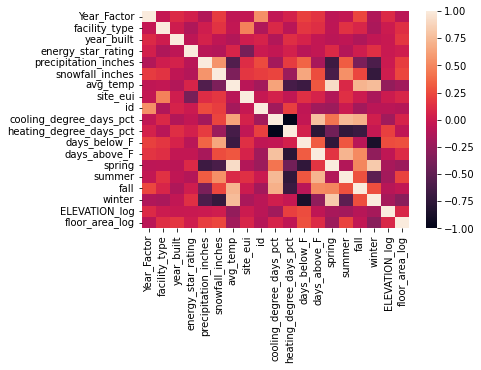

In [20]:
sns.heatmap(df.corr())

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='site_eui', ylabel='Density'>

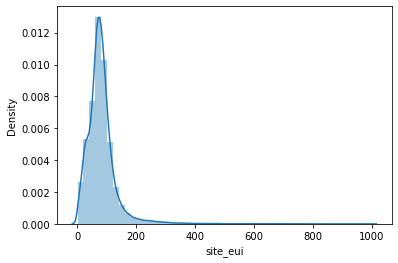

In [21]:
sns.distplot(df["site_eui"])

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='energy_star_rating', ylabel='Density'>

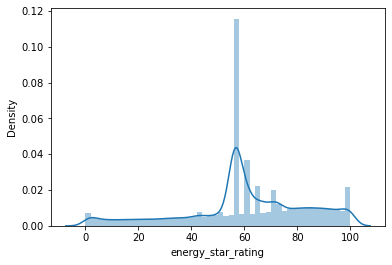

In [22]:
sns.distplot(df['energy_star_rating'])

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='floor_area_log', ylabel='Density'>

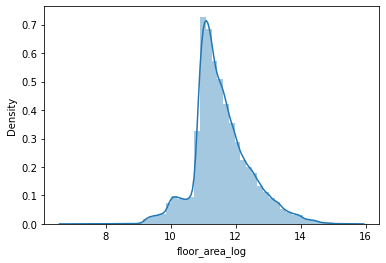

In [23]:
sns.distplot(df['floor_area_log'])

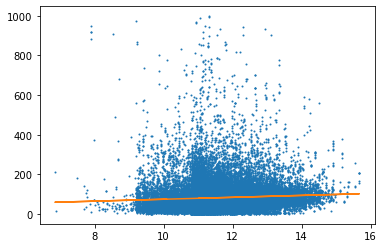

In [24]:
x = df['floor_area_log']
y = df["site_eui"]
plt.plot(x,y, 'o', markersize=1)
m, b = np.polyfit(x,y,1)
plt.plot(x, m*x + b)

<AxesSubplot:xlabel='facility_type_s', ylabel='energy_star_rating'>

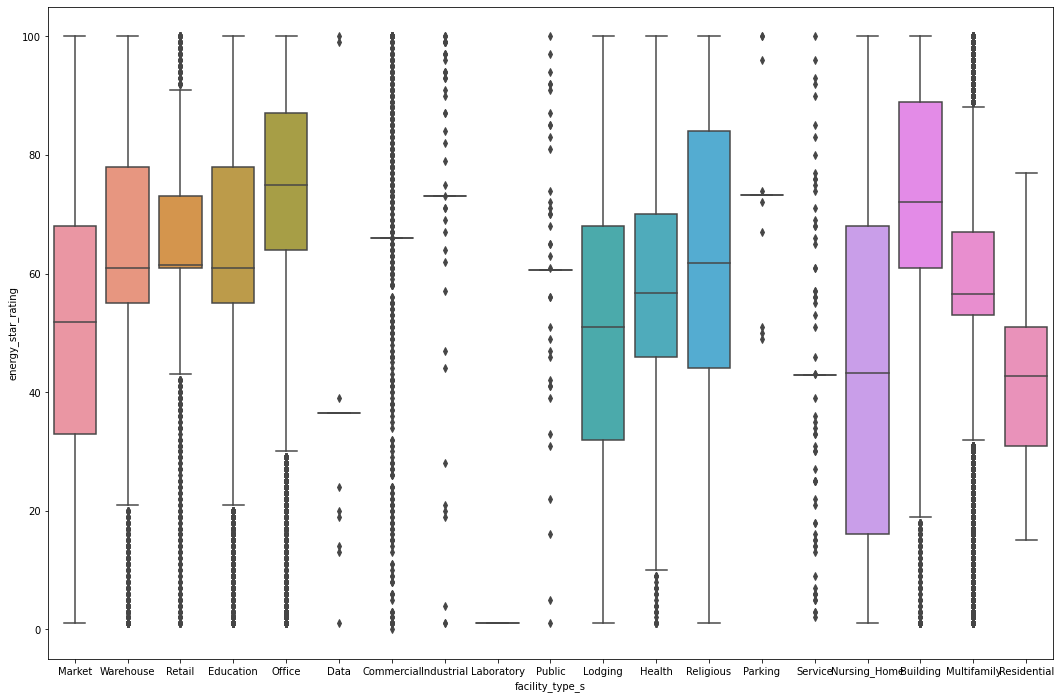

In [25]:
plt.figure(figsize=(18,12))
sns.boxplot(x='facility_type_s', y='energy_star_rating', data=df)

<AxesSubplot:xlabel='facility_type_s', ylabel='site_eui'>

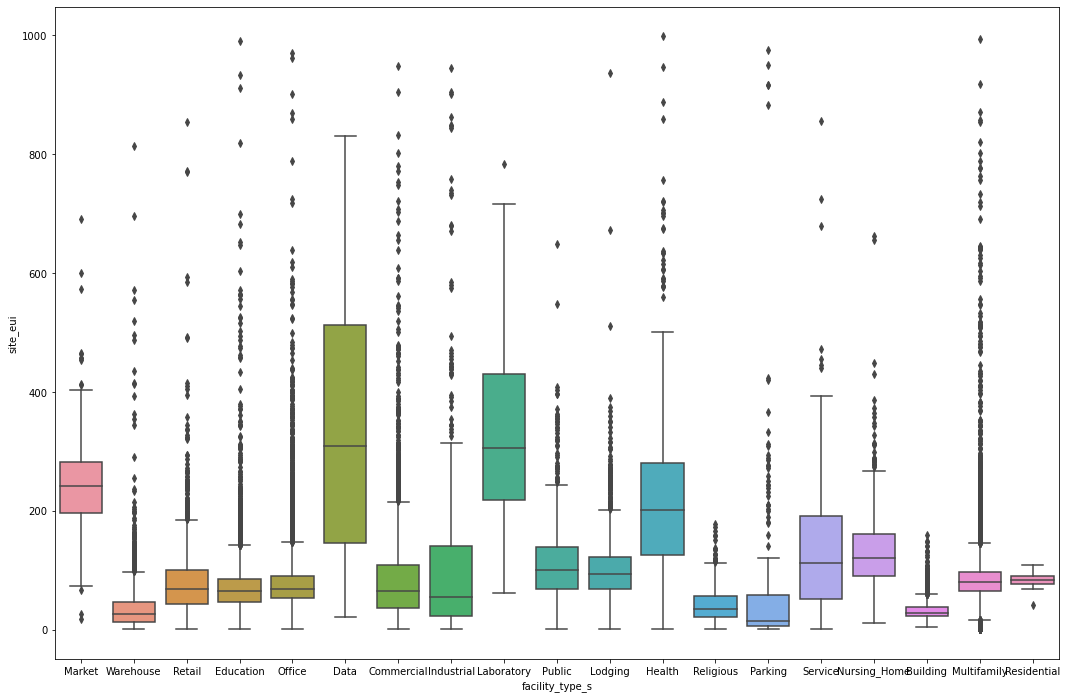

In [26]:
plt.figure(figsize=(18,12))
sns.boxplot(x='facility_type_s', y='site_eui', data=df)

<AxesSubplot:xlabel='Year_Factor', ylabel='year_built'>

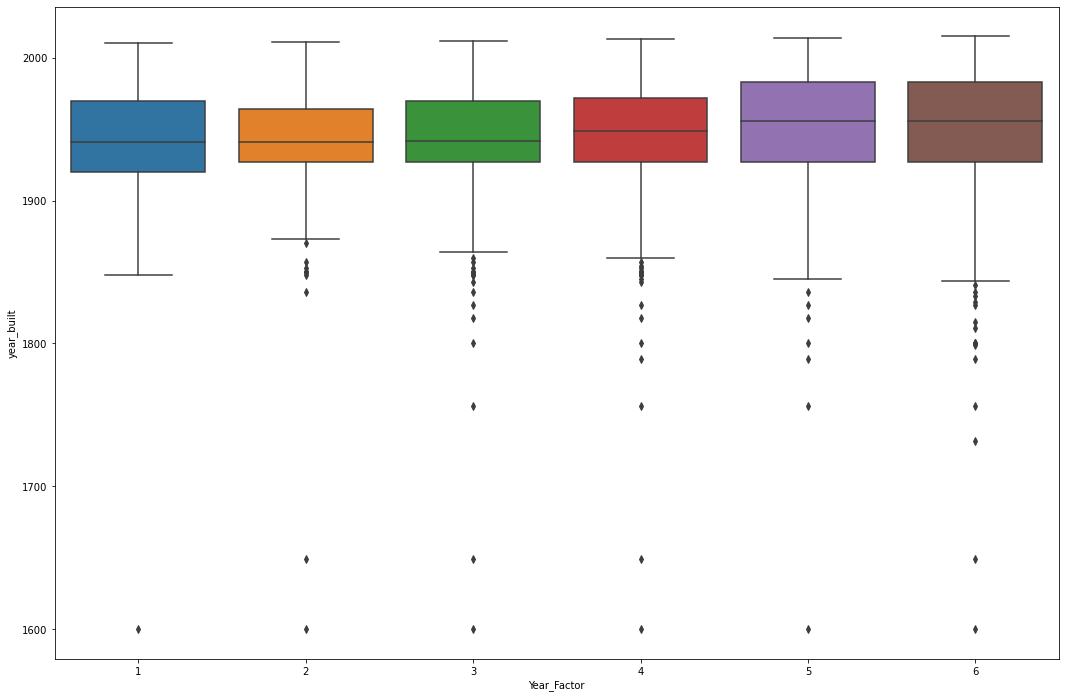

In [27]:
plt.figure(figsize=(18,12))
sns.boxplot(x='Year_Factor', y='year_built', data=df)

<AxesSubplot:xlabel='facility_type_s', ylabel='floor_area_log'>

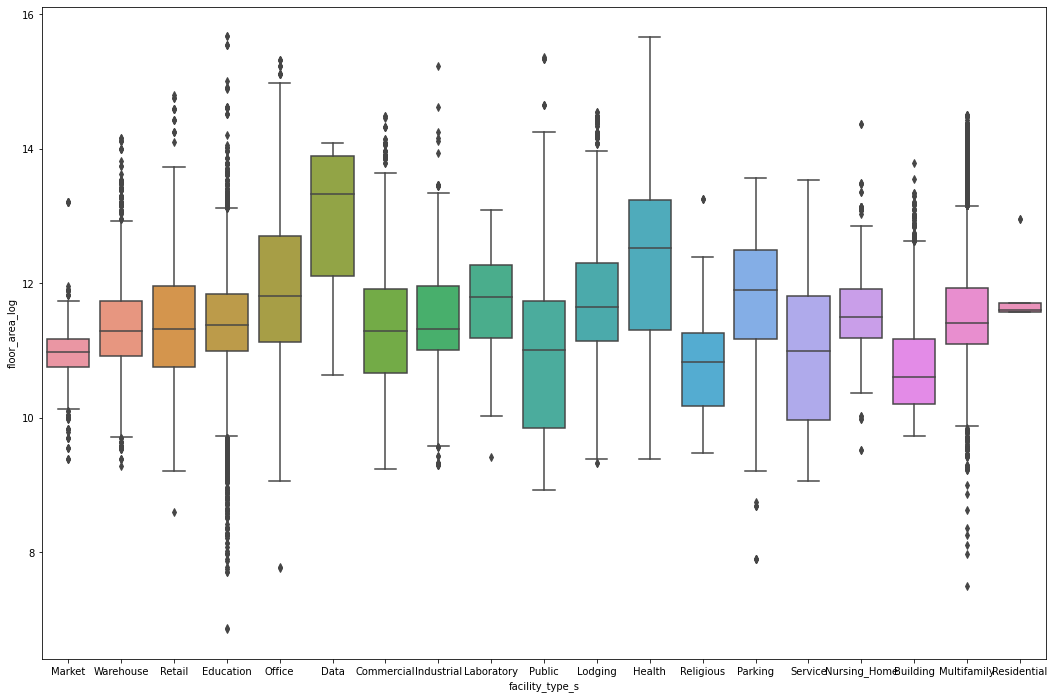

In [28]:
plt.figure(figsize=(18,12))
sns.boxplot(x='facility_type_s', y='floor_area_log', data=df)

## Build Model

### LightGBM

In [29]:
import math
from timeit import timeit

def rmse(y_test, y_pred):
    return math.sqrt(mean_squared_error(y_test, y_pred))

In [30]:
# categorical columns
categorical_cols = [
    c
    for c in df.columns
    if (1 < df[c].nunique()) & (df[c].dtype != np.number) & (df[c].dtype != int)
]
categorical_cols

/var/folders/jw/71kz1mm55lj8zynw1gmlz4_m0000gn/T/ipykernel_4049/4106884901.py:5: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if (1 < df[c].nunique()) & (df[c].dtype != np.number) & (df[c].dtype != int)


['State_Factor', 'facility_type_s']

In [31]:
no_usar=['site_eui','id']
target='site_eui'
categorical = ['facility_type_s','State_Factor']
features=[x for x in df.columns if x not in no_usar]
features

['Year_Factor',
 'State_Factor',
 'facility_type',
 'year_built',
 'energy_star_rating',
 'precipitation_inches',
 'snowfall_inches',
 'avg_temp',
 'facility_type_s',
 'cooling_degree_days_pct',
 'heating_degree_days_pct',
 'days_below_F',
 'days_above_F',
 'spring',
 'summer',
 'fall',
 'winter',
 'ELEVATION_log',
 'floor_area_log']

In [32]:
def entrena_lgb(data,test,features,categorical,target):

    kfold=GroupKFold(n_splits=6)
    i=1
    r=[]
    
    pred_test=np.zeros(len(test))
    importancias=pd.DataFrame()
    importancias['variable']=features
    
    
    cat_ind=[features.index(x) for x in categorical if x in features]
    dict_cat={}
    categorical_numerical = data[categorical].dropna().select_dtypes(include=np.number).columns.tolist()
    categorical_transform=[x for x in categorical if x not in categorical_numerical]
    
    for l in categorical_transform:
        le = LabelEncoder()
        le.fit(list(data[l].dropna())+list(test[l].dropna()))

        dict_cat[l]=le

        data.loc[~data[l].isnull(),l]=le.transform(data.loc[~data[l].isnull(),l])
        test.loc[~test[l].isnull(),l]=le.transform(test.loc[~test[l].isnull(),l])
        
    n = 0
    for train_index,test_index in kfold.split(data,data[target],data['Year_Factor']):

        lgb_data_train = lgb.Dataset(data.loc[train_index,features].values,data.loc[train_index,target].values)
        lgb_data_eval = lgb.Dataset(data.loc[test_index,features].values,data.loc[test_index,target].values, 
                                    reference=lgb_data_train)

        params = {
            'task': 'train',
            'boosting_type': 'gbdt',
            'objective': 'regression',
            'metric': { 'rmse'},
            "max_depth":-1,
            "num_leaves":32,
            'learning_rate': 0.1,
            "min_child_samples": 100,
            'feature_fraction': 0.9,
            "bagging_freq":1,
            'bagging_fraction': 0.9,
            "lambda_l1":10,
            "lambda_l2":10,
           # "scale_pos_weight":30,
            'min_data_per_group':500,
            #'verbose': 1    
        }

        modelo = lgb.train(params,lgb_data_train,num_boost_round=13100,valid_sets=lgb_data_eval,
                           early_stopping_rounds=50,verbose_eval=25,categorical_feature=cat_ind)

        importancias['gain_'+ str(i)] = modelo.feature_importance(importance_type="gain")
        
        # predict on train and val data
        data.loc[test_index,'estimator'] = modelo.predict(data.loc[test_index,features].values, num_iteration=modelo.best_iteration)
        data.loc[train_index,'estimator_train_'+str(i)] = modelo.predict(data.loc[train_index,features].values, num_iteration=modelo.best_iteration)
        
        pred_test=pred_test+modelo.predict(test[features].values, num_iteration=modelo.best_iteration)
        
        
        a= (mean_squared_error(data.loc[test_index,target], data.loc[test_index,'estimator']))**0.5
        r.append(a)
        print ("Fold_"+str(i)+': '+str(a))
        print ("")

        i=i+1
        
    for l in categorical_transform:
            data.loc[~data[l].isnull(),l]=dict_cat[l].inverse_transform(data.loc[~data[l].isnull(),l].astype(int))
            test.loc[~test[l].isnull(),l]=dict_cat[l].inverse_transform(test.loc[~test[l].isnull(),l].astype(int))
            
    importancias["gain_avg"]=importancias[["gain_1","gain_2","gain_3","gain_4","gain_5"]].mean(axis=1)
    importancias=importancias.sort_values("gain_avg",ascending=False).reset_index(drop=True)
    
    pred_test=(pred_test/6)

    oof=(mean_squared_error(data[target],data['estimator']))**0.5
    
    print (oof)
    print ("mean: "+str(np.mean(np.array(r))))
    print ("std: "+str(np.std(np.array(r))))
    
    dict_resultados={}
    dict_resultados['importancias']=importancias
    dict_resultados['predicciones']=pred_test
    dict_resultados['estimator']=data['estimator']
    dict_resultados['estimator_train_1']=data['estimator_train_1']
    dict_resultados['estimator_train_2']=data['estimator_train_2']
    dict_resultados['estimator_train_3']=data['estimator_train_3']
    dict_resultados['estimator_train_4']=data['estimator_train_4']
    dict_resultados['estimator_train_5']=data['estimator_train_5']
    dict_resultados['estimator_train_6']=data['estimator_train_6']
    dict_resultados['rmse']=r
    
    return dict_resultados

In [33]:
dict_resultados = entrena_lgb(data=df,test=test_data,features=features,categorical=categorical,target=target)

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [1, 8]
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of Lig

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1841
[LightGBM] [Info] Number of data points in the train set: 53308, number of used features: 19
[LightGBM] [Info] Start training from score 83.961575
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 41.996
[50]	valid_0's rmse: 41.6085
[75]	valid_0's rmse: 41.4205
[100]	valid_0's rmse: 41.2098
[125]	valid_0's rmse: 41.2866
[150]	valid_0's rmse: 41.2379
Early stopping, best iteration is:
[105]	valid_0's rmse: 41.1679
Fold_1: 41.167858548970706

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [1, 8]
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of Lig

[25]	valid_0's rmse: 39.8729
[50]	valid_0's rmse: 38.553
[75]	valid_0's rmse: 37.9082
[100]	valid_0's rmse: 37.4123
[125]	valid_0's rmse: 37.0406
[150]	valid_0's rmse: 36.8254
[175]	valid_0's rmse: 36.602
[200]	valid_0's rmse: 36.4014
[225]	valid_0's rmse: 36.2246
[250]	valid_0's rmse: 36.0588
[275]	valid_0's rmse: 35.8688
[300]	valid_0's rmse: 35.731
[325]	valid_0's rmse: 35.6194
[350]	valid_0's rmse: 35.4865
[375]	valid_0's rmse: 35.332
[400]	valid_0's rmse: 35.205
[425]	valid_0's rmse: 35.0785
[450]	valid_0's rmse: 35.0025
[475]	valid_0's rmse: 34.8885
[500]	valid_0's rmse: 34.8145
[525]	valid_0's rmse: 34.7317
[550]	valid_0's rmse: 34.6145
[575]	valid_0's rmse: 34.6299
[600]	valid_0's rmse: 34.5049
[625]	valid_0's rmse: 34.4642
[650]	valid_0's rmse: 34.3843
[675]	valid_0's rmse: 34.3012
[700]	valid_0's rmse: 34.216
[725]	valid_0's rmse: 34.1368
[750]	valid_0's rmse: 34.068
[775]	valid_0's rmse: 34.0279
[800]	valid_0's rmse: 33.9695
[825]	valid_0's rmse: 33.9131
[850]	valid_0's rmse

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [1, 8]
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of Lig

[25]	valid_0's rmse: 43.9887
[50]	valid_0's rmse: 42.8092
[75]	valid_0's rmse: 42.173
[100]	valid_0's rmse: 41.7219
[125]	valid_0's rmse: 41.3237
[150]	valid_0's rmse: 41.1013
[175]	valid_0's rmse: 40.8378
[200]	valid_0's rmse: 40.6403
[225]	valid_0's rmse: 40.5286
[250]	valid_0's rmse: 40.3564
[275]	valid_0's rmse: 40.1862
[300]	valid_0's rmse: 39.98
[325]	valid_0's rmse: 39.8264
[350]	valid_0's rmse: 39.6991
[375]	valid_0's rmse: 39.5848
[400]	valid_0's rmse: 39.5256
[425]	valid_0's rmse: 39.4121
[450]	valid_0's rmse: 39.3209
[475]	valid_0's rmse: 39.2393
[500]	valid_0's rmse: 39.1368
[525]	valid_0's rmse: 39.1318
[550]	valid_0's rmse: 39.156
[575]	valid_0's rmse: 39.0911
[600]	valid_0's rmse: 38.9973
[625]	valid_0's rmse: 38.9311
[650]	valid_0's rmse: 38.8499
[675]	valid_0's rmse: 38.7952
[700]	valid_0's rmse: 38.7925
[725]	valid_0's rmse: 38.753
[750]	valid_0's rmse: 38.8045
[775]	valid_0's rmse: 38.6941
[800]	valid_0's rmse: 38.6486
[825]	valid_0's rmse: 38.6405
[850]	valid_0's rm

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [1, 8]
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of Lig

[25]	valid_0's rmse: 51.8962
[50]	valid_0's rmse: 50.9763
[75]	valid_0's rmse: 50.45
[100]	valid_0's rmse: 50.1122
[125]	valid_0's rmse: 49.797
[150]	valid_0's rmse: 49.5591
[175]	valid_0's rmse: 49.2902
[200]	valid_0's rmse: 49.0755
[225]	valid_0's rmse: 48.8552
[250]	valid_0's rmse: 48.6319
[275]	valid_0's rmse: 48.5066
[300]	valid_0's rmse: 48.3559
[325]	valid_0's rmse: 48.2501
[350]	valid_0's rmse: 48.0852
[375]	valid_0's rmse: 47.9908
[400]	valid_0's rmse: 47.887
[425]	valid_0's rmse: 47.8078
[450]	valid_0's rmse: 47.7325
[475]	valid_0's rmse: 47.6651
[500]	valid_0's rmse: 47.612
[525]	valid_0's rmse: 47.5463
[550]	valid_0's rmse: 47.5182
[575]	valid_0's rmse: 47.4256
[600]	valid_0's rmse: 47.342
[625]	valid_0's rmse: 47.2808
[650]	valid_0's rmse: 47.2163
[675]	valid_0's rmse: 47.1655
[700]	valid_0's rmse: 47.1138
[725]	valid_0's rmse: 47.0699
[750]	valid_0's rmse: 47.0105
[775]	valid_0's rmse: 46.9588
[800]	valid_0's rmse: 46.9381
[825]	valid_0's rmse: 46.8839
[850]	valid_0's rms

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [1, 8]
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of Lig

[25]	valid_0's rmse: 46.649
[50]	valid_0's rmse: 45.7479
[75]	valid_0's rmse: 45.3138
[100]	valid_0's rmse: 45.0047
[125]	valid_0's rmse: 44.8558
[150]	valid_0's rmse: 44.6482
[175]	valid_0's rmse: 44.5026
[200]	valid_0's rmse: 44.3741
[225]	valid_0's rmse: 44.2518
[250]	valid_0's rmse: 44.1615
[275]	valid_0's rmse: 44.0386
[300]	valid_0's rmse: 43.9911
[325]	valid_0's rmse: 43.8757
[350]	valid_0's rmse: 43.7962
[375]	valid_0's rmse: 43.7214
[400]	valid_0's rmse: 43.6171
[425]	valid_0's rmse: 43.5052
[450]	valid_0's rmse: 43.4359
[475]	valid_0's rmse: 43.292
[500]	valid_0's rmse: 43.2452
[525]	valid_0's rmse: 43.1861
[550]	valid_0's rmse: 43.1529
[575]	valid_0's rmse: 43.1134
[600]	valid_0's rmse: 43.0347
[625]	valid_0's rmse: 42.9742
[650]	valid_0's rmse: 42.9069
[675]	valid_0's rmse: 42.8689
[700]	valid_0's rmse: 42.8277
[725]	valid_0's rmse: 42.7812
[750]	valid_0's rmse: 42.7468
[775]	valid_0's rmse: 42.7069
[800]	valid_0's rmse: 42.6518
[825]	valid_0's rmse: 42.603
[850]	valid_0's 

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [1, 8]
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of Lig

[25]	valid_0's rmse: 63.7429
[50]	valid_0's rmse: 61.8025
[75]	valid_0's rmse: 60.8183
[100]	valid_0's rmse: 60.0639
[125]	valid_0's rmse: 59.4293
[150]	valid_0's rmse: 59.0769
[175]	valid_0's rmse: 58.6603
[200]	valid_0's rmse: 58.2532
[225]	valid_0's rmse: 57.9832
[250]	valid_0's rmse: 57.6592
[275]	valid_0's rmse: 57.4789
[300]	valid_0's rmse: 57.2936
[325]	valid_0's rmse: 57.132
[350]	valid_0's rmse: 56.9175
[375]	valid_0's rmse: 56.6711
[400]	valid_0's rmse: 56.5131
[425]	valid_0's rmse: 56.3228
[450]	valid_0's rmse: 56.2633
[475]	valid_0's rmse: 56.1283
[500]	valid_0's rmse: 56.0492
[525]	valid_0's rmse: 55.9556
[550]	valid_0's rmse: 55.8602
[575]	valid_0's rmse: 55.7728
[600]	valid_0's rmse: 55.7117
[625]	valid_0's rmse: 55.5935
[650]	valid_0's rmse: 55.5345
[675]	valid_0's rmse: 55.417
[700]	valid_0's rmse: 55.3459
[725]	valid_0's rmse: 55.2175
[750]	valid_0's rmse: 55.1132
[775]	valid_0's rmse: 55.0754
[800]	valid_0's rmse: 55.0384
[825]	valid_0's rmse: 54.9903
[850]	valid_0's

In [34]:
dict_resultados['rmse']

[41.167858548970706,
 33.62177300984027,
 38.39783738387199,
 46.404559037820945,
 42.384297204136516,
 53.65184406615254]

<BarContainer object of 19 artists>

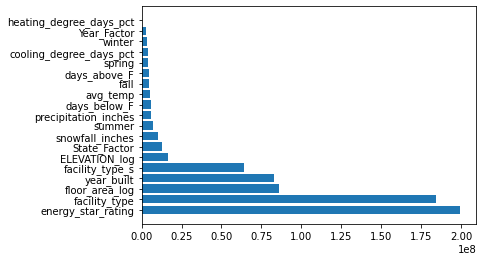

In [35]:
data = dict_resultados['importancias'].sort_values('gain_avg', ascending=False).head(20)
plt.barh('variable','gain_avg',data=data)

In [36]:
temp=dict_resultados['importancias']
features_selected=temp['variable'].tolist()[0:5]
features_selected

['energy_star_rating',
 'facility_type',
 'floor_area_log',
 'year_built',
 'facility_type_s']

In [37]:
dict_resultados_2=entrena_lgb(data=df,test=test_data,features=features_selected,categorical=categorical,target=target)

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [4]
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightG

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 618
[LightGBM] [Info] Number of data points in the train set: 53308, number of used features: 5
[LightGBM] [Info] Start training from score 83.961575
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 42.3651
[50]	valid_0's rmse: 41.5715
[75]	valid_0's rmse: 41.0514
[100]	valid_0's rmse: 40.703
[125]	valid_0's rmse: 40.4665
[150]	valid_0's rmse: 40.2896
[175]	valid_0's rmse: 40.1305
[200]	valid_0's rmse: 39.9704
[225]	valid_0's rmse: 39.9034
[250]	valid_0's rmse: 39.7387
[275]	valid_0's rmse: 39.5943
[300]	valid_0's rmse: 39.503
[325]	valid_0's rmse: 39.371
[350]	valid_0's rmse: 39.2438
[375]	valid_0's rmse: 39.1808
[400]	valid_0's rmse: 39.0528
[425]	valid_0's rmse: 38.9553
[450]	valid_0's rmse: 38.84

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [4]
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightG

[25]	valid_0's rmse: 40.1472
[50]	valid_0's rmse: 39.0242
[75]	valid_0's rmse: 38.4166
[100]	valid_0's rmse: 37.9119
[125]	valid_0's rmse: 37.4907
[150]	valid_0's rmse: 37.1472
[175]	valid_0's rmse: 36.8309
[200]	valid_0's rmse: 36.5746
[225]	valid_0's rmse: 36.3062
[250]	valid_0's rmse: 36.0735
[275]	valid_0's rmse: 35.8218
[300]	valid_0's rmse: 35.6222
[325]	valid_0's rmse: 35.4324
[350]	valid_0's rmse: 35.2193
[375]	valid_0's rmse: 35.0391
[400]	valid_0's rmse: 34.8702
[425]	valid_0's rmse: 34.6954
[450]	valid_0's rmse: 34.557
[475]	valid_0's rmse: 34.411
[500]	valid_0's rmse: 34.2761
[525]	valid_0's rmse: 34.1173
[550]	valid_0's rmse: 33.9765
[575]	valid_0's rmse: 33.8431
[600]	valid_0's rmse: 33.7348
[625]	valid_0's rmse: 33.6102
[650]	valid_0's rmse: 33.4747
[675]	valid_0's rmse: 33.3513
[700]	valid_0's rmse: 33.2548
[725]	valid_0's rmse: 33.1448
[750]	valid_0's rmse: 33.0384
[775]	valid_0's rmse: 32.9643
[800]	valid_0's rmse: 32.8685
[825]	valid_0's rmse: 32.7805
[850]	valid_0's

[6725]	valid_0's rmse: 27.475
Early stopping, best iteration is:
[6679]	valid_0's rmse: 27.4738
Fold_2: 27.473813574615125

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 623
[LightGBM] [Info] Number of data points in the train set: 62811, number of used features: 5
[LightGBM] [Info] Start training from score 81.676424
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 44.3073


/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [4]
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightG

[50]	valid_0's rmse: 43.0699
[75]	valid_0's rmse: 42.3836
[100]	valid_0's rmse: 41.866
[125]	valid_0's rmse: 41.4487
[150]	valid_0's rmse: 41.0826
[175]	valid_0's rmse: 40.7433
[200]	valid_0's rmse: 40.4415
[225]	valid_0's rmse: 40.1423
[250]	valid_0's rmse: 39.8762
[275]	valid_0's rmse: 39.605
[300]	valid_0's rmse: 39.39
[325]	valid_0's rmse: 39.1837
[350]	valid_0's rmse: 39.0036
[375]	valid_0's rmse: 38.8143
[400]	valid_0's rmse: 38.669
[425]	valid_0's rmse: 38.4901
[450]	valid_0's rmse: 38.3339
[475]	valid_0's rmse: 38.1767
[500]	valid_0's rmse: 38.0353
[525]	valid_0's rmse: 37.9031
[550]	valid_0's rmse: 37.798
[575]	valid_0's rmse: 37.6731
[600]	valid_0's rmse: 37.5852
[625]	valid_0's rmse: 37.4598
[650]	valid_0's rmse: 37.3518
[675]	valid_0's rmse: 37.262
[700]	valid_0's rmse: 37.162
[725]	valid_0's rmse: 37.0703
[750]	valid_0's rmse: 36.967
[775]	valid_0's rmse: 36.8805
[800]	valid_0's rmse: 36.8059
[825]	valid_0's rmse: 36.7303
[850]	valid_0's rmse: 36.6559
[875]	valid_0's rmse:

[6725]	valid_0's rmse: 32.1368
[6750]	valid_0's rmse: 32.1301
[6775]	valid_0's rmse: 32.1243
[6800]	valid_0's rmse: 32.1195
[6825]	valid_0's rmse: 32.1107
[6850]	valid_0's rmse: 32.1067
[6875]	valid_0's rmse: 32.0979
[6900]	valid_0's rmse: 32.0868
[6925]	valid_0's rmse: 32.0722
[6950]	valid_0's rmse: 32.0728
[6975]	valid_0's rmse: 32.0618
[7000]	valid_0's rmse: 32.0541
[7025]	valid_0's rmse: 32.054
[7050]	valid_0's rmse: 32.0442
[7075]	valid_0's rmse: 32.0289
[7100]	valid_0's rmse: 32.029
[7125]	valid_0's rmse: 32.0239
[7150]	valid_0's rmse: 32.0232
[7175]	valid_0's rmse: 32.0196
[7200]	valid_0's rmse: 32.0186
[7225]	valid_0's rmse: 32.0027
[7250]	valid_0's rmse: 31.9946
[7275]	valid_0's rmse: 31.9901
[7300]	valid_0's rmse: 31.9907
[7325]	valid_0's rmse: 31.9805
[7350]	valid_0's rmse: 31.9698
[7375]	valid_0's rmse: 31.9643
[7400]	valid_0's rmse: 31.9615
[7425]	valid_0's rmse: 31.9569
[7450]	valid_0's rmse: 31.9536
[7475]	valid_0's rmse: 31.9464
[7500]	valid_0's rmse: 31.9495
[7525]	val

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [4]
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightG

[75]	valid_0's rmse: 50.678
[100]	valid_0's rmse: 50.2939
[125]	valid_0's rmse: 49.9591
[150]	valid_0's rmse: 49.6091
[175]	valid_0's rmse: 49.3604
[200]	valid_0's rmse: 49.1425
[225]	valid_0's rmse: 48.8916
[250]	valid_0's rmse: 48.6633
[275]	valid_0's rmse: 48.4766
[300]	valid_0's rmse: 48.273
[325]	valid_0's rmse: 48.0861
[350]	valid_0's rmse: 47.9215
[375]	valid_0's rmse: 47.7608
[400]	valid_0's rmse: 47.6035
[425]	valid_0's rmse: 47.4879
[450]	valid_0's rmse: 47.3543
[475]	valid_0's rmse: 47.2365
[500]	valid_0's rmse: 47.1408
[525]	valid_0's rmse: 47.0445
[550]	valid_0's rmse: 46.9292
[575]	valid_0's rmse: 46.8195
[600]	valid_0's rmse: 46.7208
[625]	valid_0's rmse: 46.6427
[650]	valid_0's rmse: 46.5536
[675]	valid_0's rmse: 46.4833
[700]	valid_0's rmse: 46.4109
[725]	valid_0's rmse: 46.327
[750]	valid_0's rmse: 46.2625
[775]	valid_0's rmse: 46.2006
[800]	valid_0's rmse: 46.1318
[825]	valid_0's rmse: 46.0749
[850]	valid_0's rmse: 46.0148
[875]	valid_0's rmse: 45.9464
[900]	valid_0'

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [4]
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightG

[25]	valid_0's rmse: 46.2794
[50]	valid_0's rmse: 45.3685
[75]	valid_0's rmse: 44.8963
[100]	valid_0's rmse: 44.6354
[125]	valid_0's rmse: 44.4131
[150]	valid_0's rmse: 44.2469
[175]	valid_0's rmse: 44.0486
[200]	valid_0's rmse: 43.8956
[225]	valid_0's rmse: 43.7635
[250]	valid_0's rmse: 43.6209
[275]	valid_0's rmse: 43.4912
[300]	valid_0's rmse: 43.3882
[325]	valid_0's rmse: 43.2469
[350]	valid_0's rmse: 43.108
[375]	valid_0's rmse: 43.0339
[400]	valid_0's rmse: 42.9263
[425]	valid_0's rmse: 42.8503
[450]	valid_0's rmse: 42.7612
[475]	valid_0's rmse: 42.6939
[500]	valid_0's rmse: 42.6307
[525]	valid_0's rmse: 42.5481
[550]	valid_0's rmse: 42.506
[575]	valid_0's rmse: 42.4484
[600]	valid_0's rmse: 42.3591
[625]	valid_0's rmse: 42.2906
[650]	valid_0's rmse: 42.2228
[675]	valid_0's rmse: 42.1803
[700]	valid_0's rmse: 42.1121
[725]	valid_0's rmse: 42.0504
[750]	valid_0's rmse: 41.989
[775]	valid_0's rmse: 41.9426
[800]	valid_0's rmse: 41.8781
[825]	valid_0's rmse: 41.8371
[850]	valid_0's 

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [4]
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightG

[50]	valid_0's rmse: 63.2982
[75]	valid_0's rmse: 62.2833
[100]	valid_0's rmse: 61.5111
[125]	valid_0's rmse: 60.9097
[150]	valid_0's rmse: 60.3288
[175]	valid_0's rmse: 59.9363
[200]	valid_0's rmse: 59.6117
[225]	valid_0's rmse: 59.2624
[250]	valid_0's rmse: 58.9853
[275]	valid_0's rmse: 58.7238
[300]	valid_0's rmse: 58.4527
[325]	valid_0's rmse: 58.2853
[350]	valid_0's rmse: 58.1013
[375]	valid_0's rmse: 57.8627
[400]	valid_0's rmse: 57.655
[425]	valid_0's rmse: 57.5075
[450]	valid_0's rmse: 57.3826
[475]	valid_0's rmse: 57.2297
[500]	valid_0's rmse: 57.0774
[525]	valid_0's rmse: 56.8509
[550]	valid_0's rmse: 56.7804
[575]	valid_0's rmse: 56.6667
[600]	valid_0's rmse: 56.53
[625]	valid_0's rmse: 56.3994
[650]	valid_0's rmse: 56.2894
[675]	valid_0's rmse: 56.2005
[700]	valid_0's rmse: 56.0902
[725]	valid_0's rmse: 56.0298
[750]	valid_0's rmse: 55.8919
[775]	valid_0's rmse: 55.8385
[800]	valid_0's rmse: 55.7432
[825]	valid_0's rmse: 55.7067
[850]	valid_0's rmse: 55.6371
[875]	valid_0's

In [38]:
train_estimator = pd.concat([dict_resultados_2['estimator_train_1'],dict_resultados_2['estimator_train_2'],dict_resultados_2['estimator_train_3'],dict_resultados_2['estimator_train_4'],dict_resultados_2['estimator_train_5'],dict_resultados_2['estimator_train_6']], axis=1)
train_estimator['estimator_train'] = train_estimator.mean(axis=1)
print(rmse(df[target], train_estimator['estimator_train']))

dict_resultados_2['rmse']

26.21311327439801


[36.64260181029103,
 27.473813574615125,
 31.605223573268717,
 42.760589736412065,
 39.38333590256248,
 53.87469571857813]

In [39]:
features_selected_2=list(features_selected)
features_selected_2.extend(['State_Factor'])
features_selected_2

['energy_star_rating',
 'facility_type',
 'floor_area_log',
 'year_built',
 'facility_type_s',
 'State_Factor']

In [40]:
dict_resultados_3=entrena_lgb(data=df,test=test_data,features=features_selected_2,categorical=categorical,target=target)

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [4, 5]
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of Lig

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 625
[LightGBM] [Info] Number of data points in the train set: 53308, number of used features: 6
[LightGBM] [Info] Start training from score 83.961575
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 41.8299
[50]	valid_0's rmse: 41.601
[75]	valid_0's rmse: 41.816
Early stopping, best iteration is:
[34]	valid_0's rmse: 41.4566
Fold_1: 41.45663244267599

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000429 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 629
[LightGBM] [Info] Number of data points in the train set: 57449, number of used features: 6
[LightGBM] [Info] Start training from score 83.294250
Training un

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [4, 5]
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of Lig

[25]	valid_0's rmse: 39.641
[50]	valid_0's rmse: 38.2963
[75]	valid_0's rmse: 37.6101
[100]	valid_0's rmse: 37.1615
[125]	valid_0's rmse: 36.6818
[150]	valid_0's rmse: 36.2942
[175]	valid_0's rmse: 35.9255
[200]	valid_0's rmse: 35.6274
[225]	valid_0's rmse: 35.3499
[250]	valid_0's rmse: 35.0779
[275]	valid_0's rmse: 34.8237
[300]	valid_0's rmse: 34.6282
[325]	valid_0's rmse: 34.437
[350]	valid_0's rmse: 34.2728
[375]	valid_0's rmse: 34.0862
[400]	valid_0's rmse: 33.909
[425]	valid_0's rmse: 33.7396
[450]	valid_0's rmse: 33.5712
[475]	valid_0's rmse: 33.4074
[500]	valid_0's rmse: 33.2851
[525]	valid_0's rmse: 33.1345
[550]	valid_0's rmse: 33.0195
[575]	valid_0's rmse: 32.9052
[600]	valid_0's rmse: 32.7887
[625]	valid_0's rmse: 32.6479
[650]	valid_0's rmse: 32.5547
[675]	valid_0's rmse: 32.4468
[700]	valid_0's rmse: 32.3726
[725]	valid_0's rmse: 32.298
[750]	valid_0's rmse: 32.2092
[775]	valid_0's rmse: 32.1083
[800]	valid_0's rmse: 32.0052
[825]	valid_0's rmse: 31.9229
[850]	valid_0's r

[6725]	valid_0's rmse: 26.4301
[6750]	valid_0's rmse: 26.414
[6775]	valid_0's rmse: 26.406
[6800]	valid_0's rmse: 26.3987
[6825]	valid_0's rmse: 26.3918
[6850]	valid_0's rmse: 26.3832
[6875]	valid_0's rmse: 26.3699
[6900]	valid_0's rmse: 26.3547
[6925]	valid_0's rmse: 26.3482
[6950]	valid_0's rmse: 26.3439
[6975]	valid_0's rmse: 26.3421
[7000]	valid_0's rmse: 26.3434
[7025]	valid_0's rmse: 26.3292
[7050]	valid_0's rmse: 26.3159
[7075]	valid_0's rmse: 26.309
[7100]	valid_0's rmse: 26.3023
[7125]	valid_0's rmse: 26.2896
[7150]	valid_0's rmse: 26.2806
[7175]	valid_0's rmse: 26.278
[7200]	valid_0's rmse: 26.2705
[7225]	valid_0's rmse: 26.261
[7250]	valid_0's rmse: 26.2604
[7275]	valid_0's rmse: 26.2544
[7300]	valid_0's rmse: 26.2461
[7325]	valid_0's rmse: 26.232
[7350]	valid_0's rmse: 26.2273
[7375]	valid_0's rmse: 26.2193
[7400]	valid_0's rmse: 26.2166
[7425]	valid_0's rmse: 26.2088
[7450]	valid_0's rmse: 26.1983
[7475]	valid_0's rmse: 26.187
[7500]	valid_0's rmse: 26.1743
[7525]	valid_0'

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [4, 5]
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of Lig

[50]	valid_0's rmse: 42.3802
[75]	valid_0's rmse: 41.578
[100]	valid_0's rmse: 41.0411
[125]	valid_0's rmse: 40.5715
[150]	valid_0's rmse: 40.134
[175]	valid_0's rmse: 39.7428
[200]	valid_0's rmse: 39.4329
[225]	valid_0's rmse: 39.1875
[250]	valid_0's rmse: 38.9243
[275]	valid_0's rmse: 38.6714
[300]	valid_0's rmse: 38.4079
[325]	valid_0's rmse: 38.2191
[350]	valid_0's rmse: 38.0019
[375]	valid_0's rmse: 37.8157
[400]	valid_0's rmse: 37.6713
[425]	valid_0's rmse: 37.5203
[450]	valid_0's rmse: 37.3858
[475]	valid_0's rmse: 37.2305
[500]	valid_0's rmse: 37.0846
[525]	valid_0's rmse: 36.9655
[550]	valid_0's rmse: 36.823
[575]	valid_0's rmse: 36.7272
[600]	valid_0's rmse: 36.6393
[625]	valid_0's rmse: 36.5357
[650]	valid_0's rmse: 36.4477
[675]	valid_0's rmse: 36.3571
[700]	valid_0's rmse: 36.2636
[725]	valid_0's rmse: 36.1612
[750]	valid_0's rmse: 36.0738
[775]	valid_0's rmse: 36.0037
[800]	valid_0's rmse: 35.9187
[825]	valid_0's rmse: 35.8318
[850]	valid_0's rmse: 35.7585
[875]	valid_0's

Fold_3: 31.396901574371597

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 632
[LightGBM] [Info] Number of data points in the train set: 64878, number of used features: 6
[LightGBM] [Info] Start training from score 82.088447
Training until validation scores don't improve for 50 rounds
[25]	valid_0's rmse: 51.8795


/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [4, 5]
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of Lig

[50]	valid_0's rmse: 50.6832
[75]	valid_0's rmse: 50.1158
[100]	valid_0's rmse: 49.7126
[125]	valid_0's rmse: 49.2977
[150]	valid_0's rmse: 48.9716
[175]	valid_0's rmse: 48.6655
[200]	valid_0's rmse: 48.4336
[225]	valid_0's rmse: 48.1878
[250]	valid_0's rmse: 47.9463
[275]	valid_0's rmse: 47.7753
[300]	valid_0's rmse: 47.6088
[325]	valid_0's rmse: 47.4323
[350]	valid_0's rmse: 47.2497
[375]	valid_0's rmse: 47.0823
[400]	valid_0's rmse: 46.9247
[425]	valid_0's rmse: 46.7901
[450]	valid_0's rmse: 46.655
[475]	valid_0's rmse: 46.5269
[500]	valid_0's rmse: 46.4057
[525]	valid_0's rmse: 46.3006
[550]	valid_0's rmse: 46.1828
[575]	valid_0's rmse: 46.0532
[600]	valid_0's rmse: 45.9573
[625]	valid_0's rmse: 45.8551
[650]	valid_0's rmse: 45.7762
[675]	valid_0's rmse: 45.6994
[700]	valid_0's rmse: 45.6287
[725]	valid_0's rmse: 45.5661
[750]	valid_0's rmse: 45.4831
[775]	valid_0's rmse: 45.4193
[800]	valid_0's rmse: 45.3508
[825]	valid_0's rmse: 45.2837
[850]	valid_0's rmse: 45.218
[875]	valid_0'

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [4, 5]
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of Lig

[75]	valid_0's rmse: 44.5964
[100]	valid_0's rmse: 44.3375
[125]	valid_0's rmse: 44.0668
[150]	valid_0's rmse: 43.852
[175]	valid_0's rmse: 43.634
[200]	valid_0's rmse: 43.4891
[225]	valid_0's rmse: 43.2912
[250]	valid_0's rmse: 43.2149
[275]	valid_0's rmse: 43.0614
[300]	valid_0's rmse: 42.9345
[325]	valid_0's rmse: 42.8169
[350]	valid_0's rmse: 42.7086
[375]	valid_0's rmse: 42.628
[400]	valid_0's rmse: 42.5293
[425]	valid_0's rmse: 42.4115
[450]	valid_0's rmse: 42.3012
[475]	valid_0's rmse: 42.2301
[500]	valid_0's rmse: 42.1408
[525]	valid_0's rmse: 42.0844
[550]	valid_0's rmse: 41.9995
[575]	valid_0's rmse: 41.9604
[600]	valid_0's rmse: 41.8738
[625]	valid_0's rmse: 41.8184
[650]	valid_0's rmse: 41.7471
[675]	valid_0's rmse: 41.6909
[700]	valid_0's rmse: 41.6647
[725]	valid_0's rmse: 41.6098
[750]	valid_0's rmse: 41.5657
[775]	valid_0's rmse: 41.5168
[800]	valid_0's rmse: 41.4605
[825]	valid_0's rmse: 41.4057
[850]	valid_0's rmse: 41.3692
[875]	valid_0's rmse: 41.3344
[900]	valid_0'

/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [4, 5]
  _log_warning('categorical_feature in Dataset is overridden.\n'
/Users/vivianho/opt/anaconda3/envs/tf2/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of Lig

[25]	valid_0's rmse: 64.1551
[50]	valid_0's rmse: 61.7414
[75]	valid_0's rmse: 60.6552
[100]	valid_0's rmse: 60.0193
[125]	valid_0's rmse: 59.3852
[150]	valid_0's rmse: 58.9155
[175]	valid_0's rmse: 58.5751
[200]	valid_0's rmse: 58.2515
[225]	valid_0's rmse: 58.0079
[250]	valid_0's rmse: 57.7256
[275]	valid_0's rmse: 57.5458
[300]	valid_0's rmse: 57.4264
[325]	valid_0's rmse: 57.2174
[350]	valid_0's rmse: 57.0023
[375]	valid_0's rmse: 56.8023
[400]	valid_0's rmse: 56.6307
[425]	valid_0's rmse: 56.4556
[450]	valid_0's rmse: 56.3998
[475]	valid_0's rmse: 56.2683
[500]	valid_0's rmse: 56.1273
[525]	valid_0's rmse: 55.9579
[550]	valid_0's rmse: 55.8506
[575]	valid_0's rmse: 55.7617
[600]	valid_0's rmse: 55.6237
[625]	valid_0's rmse: 55.5119
[650]	valid_0's rmse: 55.4693
[675]	valid_0's rmse: 55.3871
[700]	valid_0's rmse: 55.348
[725]	valid_0's rmse: 55.2534
[750]	valid_0's rmse: 55.1261
[775]	valid_0's rmse: 55.0368
[800]	valid_0's rmse: 54.9355
[825]	valid_0's rmse: 54.8342
[850]	valid_0'

In [41]:
train_estimator = pd.concat([dict_resultados_3['estimator_train_1'],dict_resultados_3['estimator_train_2'],dict_resultados_3['estimator_train_3'],dict_resultados_3['estimator_train_4'],dict_resultados_3['estimator_train_5'],dict_resultados_3['estimator_train_6']], axis=1)
train_estimator['estimator_train'] = train_estimator.mean(axis=1)
print(rmse(df[target], train_estimator['estimator_train']))

dict_resultados_3['rmse']

26.495836814936474


[41.45663244267599,
 26.048845257398632,
 31.396901574371597,
 41.809762650500424,
 38.97139539722993,
 52.38064853113243]

### XGBoost

In [48]:
data=df
test=test_data
features=features
categorical=categorical
target=target

categorical

['facility_type_s', 'State_Factor']

In [47]:
df.head()

,Year_Factor,State_Factor,facility_type,year_built,energy_star_rating,precipitation_inches,snowfall_inches,avg_temp,site_eui,id,...,winter,ELEVATION_log,floor_area_log,estimator,estimator_train_1,estimator_train_2,estimator_train_3,estimator_train_4,estimator_train_5,estimator_train_6
0,1,State_1,241.135162,1942.0,11.0,16.59,0.0,56.972603,248.682615,0,...,50.12116,0.88,11.02,248.234686,265.818401,251.060270,250.261313,244.630527,252.430929,NaN
1,1,State_1,39.559542,1955.0,45.0,16.59,0.0,56.972603,26.500150,1,...,50.12116,0.59,12.52,26.058162,37.032053,23.584081,19.666078,17.071505,25.698200,NaN
2,1,State_1,100.965937,1951.0,97.0,16.59,0.0,56.972603,24.693619,2,...,50.12116,0.59,12.54,25.997089,40.932718,25.357908,24.172537,22.314546,28.942707,NaN
3,1,State_1,69.441531,1980.0,46.0,16.59,0.0,56.972603,48.406926,3,...,50.12116,0.59,10.92,50.624031,60.313272,45.397560,42.646365,47.942707,47.062413,NaN
4,1,State_1,38.209399,1985.0,100.0,16.59,0.0,56.972603,3.899395,4,...,50.12116,0.88,11.10,7.939472,15.302797,8.507385,8.393276,7.095616,10.939976,NaN


In [51]:
def entrena_xgb(data,test,features,categorical,target):

    kfold=GroupKFold(n_splits=6)  
    
    importancias_all=[]

    i=1
    r=[]
    pred_test=np.zeros(len(test))
    dtest = xgb.DMatrix(test[features].values)
    
    cat_ind=[features.index(x) for x in categorical if x in features]
    dict_cat={}
    categorical_numerical = data[categorical].dropna().select_dtypes(include=np.number).columns.tolist()
    categorical_transform=[x for x in categorical if x not in categorical_numerical]
    
    for l in categorical_transform:
        le = LabelEncoder()
        le.fit(list(data[l].dropna())+list(test[l].dropna()))

        dict_cat[l]=le

        data.loc[~data[l].isnull(),l]=le.transform(data.loc[~data[l].isnull(),l])
        test.loc[~test[l].isnull(),l]=le.transform(test.loc[~test[l].isnull(),l])
        
    n = 0
    
    for train_index, test_index in kfold.split(data,data[target],data['Year_Factor']):

        dtrain = xgb.DMatrix(data.loc[train_index,features].values,data.loc[train_index,target].values)
        dval = xgb.DMatrix(data.loc[test_index,features].values,data.loc[test_index,target].values)

        num_round = 2
        params = {'eval_metric': 'rmse', 'learning_rate': 0.8, 'max_depth': 5,
         "grow_policy": 'lossguide','gamma': 0.3, 'verbosity':1}
        bst = xgb.train(params, dtrain, num_round)

        importancias = bst.get_score(importance_type='gain')
        importancias_all.append(importancias)
        
        ypred_train = bst.predict(dtrain)
        ypred_val = bst.predict(dval)
        data.loc[test_index,'estimator'] = bst.predict(dval)
        
        print(rmse(data.loc[train_index,target], ypred_train))
        print(rmse(data.loc[test_index,target], ypred_val))
        

        pred_test = pred_test+bst.predict(dtest)
        
        a= (mean_squared_error(data.loc[test_index,target], data.loc[test_index,'estimator']))**0.5
        r.append(a)
        
        i+=1

    for l in categorical_transform:
        data.loc[~data[l].isnull(),l]=dict_cat[l].inverse_transform(data.loc[~data[l].isnull(),l].astype(int))
        test.loc[~test[l].isnull(),l]=dict_cat[l].inverse_transform(test.loc[~test[l].isnull(),l].astype(int))
           
    pred_test=(pred_test/6)
    
    dict_resultados={}
    dict_resultados['importancias']=pd.DataFrame(importancias_all).mean().sort_values(ascending=False)
    dict_resultados['predicciones']=pred_test
    dict_resultados['estimator']=data['estimator']
    dict_resultados['rmse']=r
    
    return dict_resultados

In [52]:
dict_result_xgb1=entrena_xgb(data=df,test=test_data,features=features,categorical=categorical,target=target)
np.mean(dict_result_xgb1['rmse'])
#dict_result_xgb1['importancias']

45.508578344033005
47.99307968963273
45.834960336581176
40.55276798726016
45.09436663385932
46.02996069707679
43.48761257259383
53.25125369323745
44.625775547982116
46.38496688005034
44.15598519755403
64.22703898077532


49.73984465467213

In [53]:
features_selected = ['facility_type', 'energy_star_rating','facility_type_s', 'State_Factor']
features_selected

['facility_type', 'energy_star_rating', 'facility_type_s', 'State_Factor']

In [54]:
dict_result_xgb2=entrena_xgb(data=df,test=test_data,features=features_selected,categorical=categorical,target=target)
print(dict_result_xgb2['rmse'])
dict_result_xgb2['importancias']

45.95455670405398
42.503915894899784
46.29521892283004
40.7874577226906
45.209640902156
44.808995263912806
44.08333719303238
53.140161134196205
44.93836873109726
47.58496816803798
44.45193972218286
66.81252092919357
[42.503915894899784, 40.7874577226906, 44.808995263912806, 53.140161134196205, 47.58496816803798, 66.81252092919357]


f0    2.300380e+06
f1    1.903844e+06
f2    3.824467e+05
f3    3.209282e+05
dtype: float64

## Make predictions on test data(hold-out dataset)

In [42]:
test_data['site_eui']=(dict_resultados_2['predicciones'].copy()+dict_resultados_3['predicciones'].copy())/2
test_data[['id','site_eui']].to_csv('submission.csv',index=False)

In [43]:
test_data[['id','site_eui']]

,id,site_eui
0,75757,184.919325
1,75758,241.089412
2,75759,193.492021
3,75760,259.856221
4,75761,241.266703
...,...,...
9700,85457,23.150595
9701,85458,36.080152
9702,85459,34.777639
9703,85460,27.909155


## Evaluate Performance

In [55]:
df['error'] = df['estimator'] - df['site_eui']
df['absolute error'] = df['error'].abs()

Text(0.5, 0, 'y actual')

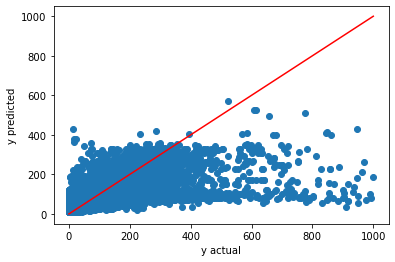

In [56]:
plt.scatter(df['site_eui'], df['estimator'])
x = np.linspace(0, 1000)
plt.plot(x, x, color='r')
plt.ylabel('y predicted')
plt.xlabel('y actual')

Text(0, 0.5, 'y predicted')

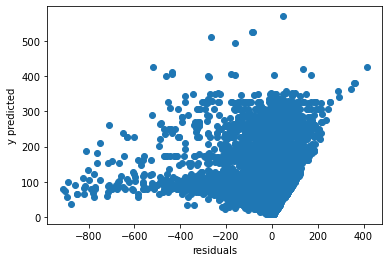

In [57]:
plt.scatter(df['error'], df['estimator'])
plt.xlabel('residuals')
plt.ylabel('y predicted')

Text(0, 0.5, 'y actual')

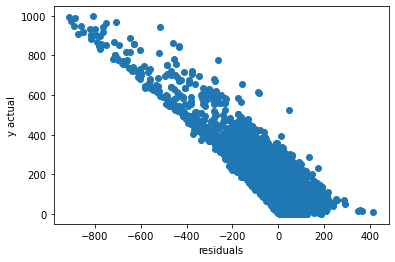

In [58]:
plt.scatter(df['error'],df['site_eui'])
plt.xlabel('residuals')
plt.ylabel('y actual')

In [59]:
pd.set_option('display.max_columns',None)
df.sort_values('absolute error', ascending=False).head(10)

,Year_Factor,State_Factor,facility_type,year_built,energy_star_rating,precipitation_inches,snowfall_inches,avg_temp,site_eui,id,facility_type_s,cooling_degree_days_pct,heating_degree_days_pct,days_below_F,days_above_F,spring,summer,fall,winter,ELEVATION_log,floor_area_log,estimator,estimator_train_1,estimator_train_2,estimator_train_3,estimator_train_4,estimator_train_5,estimator_train_6,error,absolute error
28951,3,5,83.878522,1951.000000,56.548516,46.32,29.6,55.449315,993.428259,28951,9,0.214069,0.785931,61,86,51.972939,75.695161,57.770072,35.846582,2.72,11.32,79.638451,85.913732,210.946746,186.507235,NaN,171.572091,125.616353,-913.789809,913.789809
28107,3,5,67.351241,1914.000000,73.222222,46.32,29.6,55.449315,975.452321,28107,12,0.214069,0.785931,61,86,51.972939,75.695161,57.770072,35.846582,2.72,9.21,72.486801,178.733893,883.395777,850.891198,NaN,820.675992,700.381012,-902.965520,902.965520
46312,5,5,67.351241,1955.000000,73.222222,40.97,49.1,56.835616,950.306820,46312,12,0.261712,0.738288,106,118,53.620968,76.313799,61.760573,34.858487,3.24,7.90,57.220360,189.768335,NaN,887.000241,876.342981,856.013361,817.352436,-893.086460,893.086460
55578,6,5,108.629116,1930.000000,61.011385,42.17,36.0,57.215847,989.887978,55578,3,0.259362,0.740638,54,113,54.998208,76.701613,60.108244,36.832406,1.22,11.05,100.600372,NaN,526.142174,462.648888,421.442534,375.163010,279.997845,-889.287606,889.287606
359,2,0,46.172799,1940.762819,61.011385,10.43,0.0,64.251366,910.563198,359,3,0.455206,0.544794,0,75,60.171685,67.838889,68.846953,60.087319,3.39,8.52,35.660252,63.254346,63.617849,67.754885,71.466176,NaN,62.499611,-874.902946,874.902946
20326,2,5,92.642037,1967.000000,65.993814,38.51,9.6,57.366120,948.758564,20326,1,0.243007,0.756993,27,89,56.932975,75.478315,56.905018,39.889878,3.09,11.19,89.544563,99.023525,674.601934,625.972559,600.689160,NaN,378.555854,-859.214001,859.214001
17072,2,5,67.351241,1955.000000,73.222222,38.51,9.6,57.366120,916.337619,17072,12,0.243007,0.756993,27,89,56.932975,75.478315,56.905018,39.889878,3.24,7.90,65.224869,189.768335,870.934682,887.000241,876.342981,NaN,817.352436,-851.112750,851.112750
58024,6,5,67.351241,1955.000000,73.222222,42.17,36.0,57.215847,916.389344,58024,12,0.259362,0.740638,54,113,54.998208,76.701613,60.108244,36.832406,3.75,7.90,66.221817,NaN,870.934682,887.000241,876.342981,856.013361,817.352436,-850.167527,850.167527
9527,6,3,108.629116,1973.000000,61.011385,37.12,30.0,57.443182,933.427176,9527,3,0.275053,0.724947,93,147,55.437973,77.915443,60.402915,35.646914,1.10,12.95,110.475647,NaN,628.505667,660.626961,622.512944,607.315063,530.481707,-822.951529,822.951529
45003,5,5,77.074389,1988.000000,71.300332,40.97,49.1,56.835616,901.092991,45003,11,0.261712,0.738288,106,118,53.620968,76.313799,61.760573,34.858487,3.75,11.55,82.008568,112.358098,NaN,404.503168,375.380156,212.129691,230.046204,-819.084423,819.084423


<AxesSubplot:xlabel='facility_type', ylabel='error'>

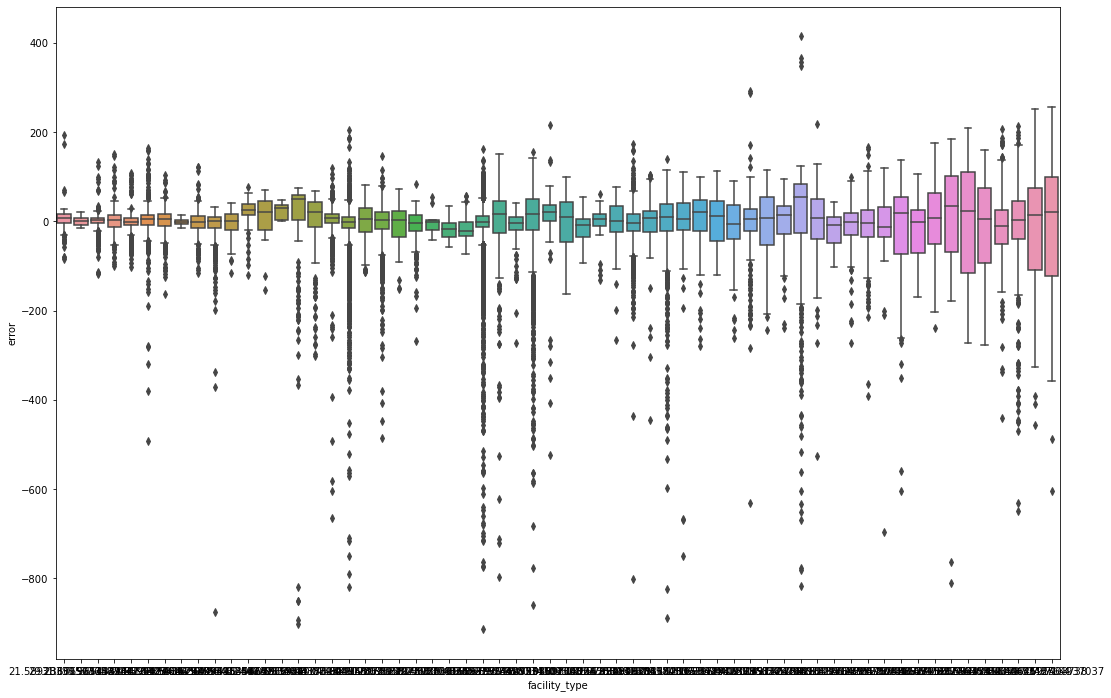

In [60]:
plt.figure(figsize=(18,12))
sns.boxplot(x='facility_type', y='error', data=df)